In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import boto3
%matplotlib inline

In [2]:
labels = pd.read_csv("s3://dogfaces/tensor_model/output_labels_20170907.txt", names=["dog_breed"])
labels.head()

,dog_breed
0,rottweiler
1,bull mastiff
2,french bulldog
3,cairn
4,yorkshire terrier


### Get confusion matrix

In [3]:
df_conf = pd.read_csv("s3://dogfaces/tensor_model/test_result_20170907.txt", sep=" ", names=["image_name", "pred", "actual"])

In [4]:
df_conf.tail()

,image_name,pred,actual
953,train_images/West_Highland_white_terrier/n0209...,52,52
954,train_images/West_Highland_white_terrier/n0209...,52,52
955,train_images/West_Highland_white_terrier/n0209...,52,52
956,train_images/West_Highland_white_terrier/n0209...,52,52
957,train_images/West_Highland_white_terrier/n0209...,52,52


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    '''
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    '''

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
y_pred = df_conf['pred']
y_true = df_conf['actual']

Normalized confusion matrix
[[ 1.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    1.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.94 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  1.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.85  0.  ]
 [ 0.    0.    0.   ...,  0.    0.    1.  ]]


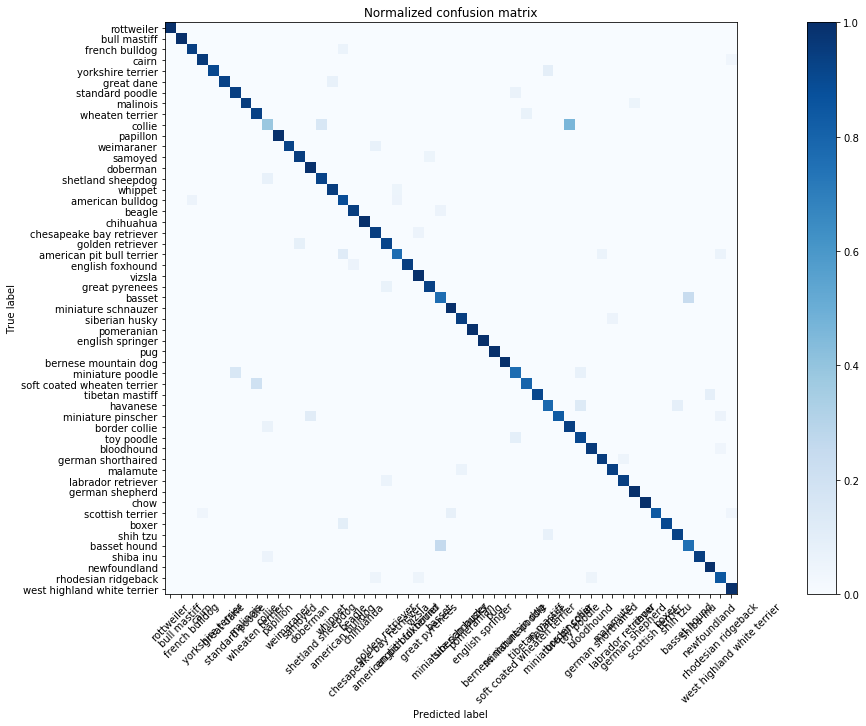

In [7]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure(figsize=(10,10))
#plot_confusion_matrix(cnf_matrix, classes=labels.dog_breed,
#                      title='Confusion matrix, without normalization')
#plt.show()

#Plot normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=labels.dog_breed, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Examine model images

In [8]:
breed_names = labels.dog_breed.values

In [9]:
df_revpics = pd.read_csv("s3://dogfaces/reviews/labeled_pictures.csv")
df_revpics.head()

,pic_names,probability
0,0090-en_us_1395941_photo.jpg,"[0.995804, 0.00103013, 8.67468e-06, 1.25309e-0..."
1,0090-en_us_2278266_photo.jpg,"[0.000183522, 0.00523787, 0.0364081, 0.0026475..."
2,0090-en_us_1719425_photo.jpg,"[0.0147026, 0.000886808, 0.00103998, 0.0013103..."
3,0090-en_us_1892461_photo.jpg,"[0.000591641, 0.00258964, 0.000426093, 0.00229..."
4,0090-en_us_304189_photo.jpg,"[0.0014609, 0.00287083, 0.00435399, 0.00102825..."


In [10]:
def prob2num(row):
    return map(lambda x:float(x), row.lstrip('[').rstrip(']').split(','))
def getTopbreed(prob,k, thres=0.1):
    prob_num = prob2num(prob)
    prob_index = np.argsort(prob_num)[-k]
    pred = breed_names[prob_index]
    prob_digi = prob_num[prob_index]
    if prob_digi > thres:
        return pred
    else:
        return 'unknown'

In [11]:
df_a = pd.DataFrame()

In [12]:
df_a['top1'] = df_revpics['probability'].apply(lambda row:getTopbreed(row, 1))

In [13]:
df_a['top1'].head()

0                   rottweiler
1    american pit bull terrier
2           miniature pinscher
3    american pit bull terrier
4                     malinois
Name: top1, dtype: object

In [14]:
df_a['top1'].value_counts()

unknown                        421
american pit bull terrier      192
labrador retriever             173
german shepherd                137
golden retriever               105
beagle                          97
chihuahua                       85
havanese                        84
american bulldog                76
toy poodle                      73
miniature pinscher              73
shih tzu                        69
whippet                         66
french bulldog                  65
doberman                        56
shiba inu                       53
yorkshire terrier               51
rottweiler                      50
boxer                           48
great dane                      44
malinois                        43
border collie                   42
german shorthaired              32
rhodesian ridgeback             30
west highland white terrier     27
miniature schnauzer             25
siberian husky                  25
miniature poodle                22
vizsla              

In [96]:
df_a['top2'] = df_revpics['probability'].apply(lambda row:getTopbreed(row, 2, thres=0.05))

In [97]:
df_a['top2'].value_counts()

unknown                        664
american pit bull terrier      131
american bulldog               120
miniature pinscher             107
chihuahua                       96
labrador retriever              96
havanese                        82
beagle                          80
shih tzu                        72
malinois                        62
whippet                         60
toy poodle                      59
shiba inu                       59
collie                          53
german shepherd                 46
boxer                           46
doberman                        45
golden retriever                41
chesapeake bay retriever        41
scottish terrier                38
miniature poodle                37
wheaten terrier                 36
standard poodle                 34
great dane                      33
german shorthaired              32
soft coated wheaten terrier     30
rhodesian ridgeback             25
french bulldog                  23
miniature schnauzer 

In [99]:
df_a['top3'] = df_revpics['probability'].apply(lambda row:getTopbreed(row, 3, thres=0.05))

In [100]:
df_a['top3'].value_counts()

unknown                        1351
american pit bull terrier        75
chihuahua                        64
miniature pinscher               63
beagle                           57
american bulldog                 57
havanese                         57
labrador retriever               55
whippet                          54
shiba inu                        48
shih tzu                         40
boxer                            37
toy poodle                       30
french bulldog                   29
chesapeake bay retriever         28
german shepherd                  27
collie                           27
doberman                         26
malinois                         25
golden retriever                 24
wheaten terrier                  23
soft coated wheaten terrier      23
standard poodle                  22
rottweiler                       22
great dane                       21
yorkshire terrier                21
siberian husky                   20
border collie               

In [101]:
df_a.shape

(2619, 3)

In [102]:
df_calc = pd.concat([df_revpics['pic_names'], df_a], axis=1)

In [103]:
df_calc[df_calc['top1']=='unknown'].sample(10)

,pic_names,top1,top2,top3
1479,0090-en_us_2409909_photo.jpg,unknown,collie,unknown
722,0090-en_us_2393501_photo.jpg,unknown,chihuahua,french bulldog
2322,0090-en_us_968270_photo.jpg,unknown,unknown,unknown
2425,0090-en_us_269147_photo.jpg,unknown,unknown,unknown
1923,0090-en_us_963563_photo.jpg,unknown,tibetan mastiff,unknown
2010,0090-en_us_2379105_photo.jpg,unknown,unknown,unknown
1804,0090-en_us_943117_photo.jpg,unknown,unknown,unknown
325,0090-en_us_2404039_photo.jpg,unknown,collie,shih tzu
411,0090-en_us_906430_photo.jpg,unknown,miniature pinscher,chihuahua
1978,0090-en_us_924606_photo.jpg,unknown,unknown,unknown


### Display images

In [52]:
s3 = boto3.client("s3")

In [53]:
def getReviewPicFromS3(pic_name, s3):
    pic_Key = "reviews/review_pics/"+pic_name
    pic_object = s3.get_object(Bucket='dogfaces', Key=pic_Key)
    pic_content = pic_object['Body'].read()
    return pic_content

In [61]:
test_name = "0090-en_us_1428965_photo.jpg"
pic_to_show = getReviewPicFromS3(test_name, s3)
with open('photo.jpg', 'wb') as f:
    f.write(pic_to_show)

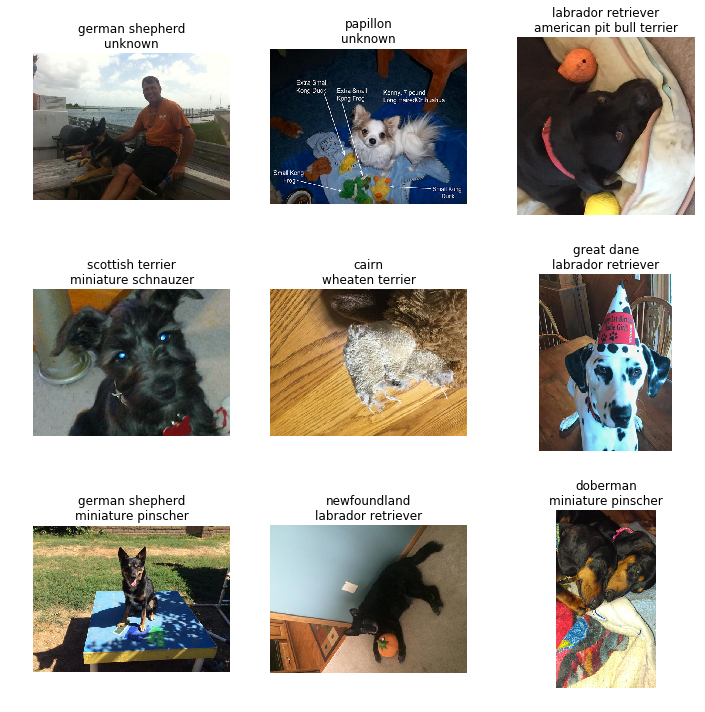

In [146]:
# plot classified pictures
samples = df_calc[df_calc['top1']!='unknown'].sample(9)
image_names = samples.pic_names.values
breeds_1 = samples.top1.values
breeds_2 = samples.top2.values
fig, axes = plt.subplots(3,3, figsize=(10,10))
for img_name,breed1,breed2, ax in zip(image_names, breeds_1,breeds_2, axes.flatten()):
    pic_to_show = getReviewPicFromS3(img_name, s3)
    with open('photo.jpg', 'wb') as f:
        f.write(pic_to_show)
    ax.imshow(plt.imread('photo.jpg'))
    ax.axis("off")
    ax.set_title(breed1+"\n"+breed2)
plt.tight_layout()
plt.show()

### Examine user information

In [58]:
df_users = pd.read_csv("s3://dogfaces/reviews/reviews.csv")

In [60]:
len(df_users['user_name'].unique())

32702

In [61]:
df_users.shape

(61202, 7)

In [62]:
df_users['user_name'].value_counts()

Lisa             86
Sandy            68
Chris            67
Debbie           67
Linda            63
Bella            63
Mary             63
Cindy            63
Sarah            61
Kathy            61
Kate             61
Karen            61
Katie            58
Dogmom           58
Daisy            56
Barb             55
Jenn             54
Kelly            53
Carol            53
Jess             53
Amanda           51
Lori             49
Laura            49
Nancy            48
Doglover         47
Michelle         46
Tina             45
Donna            45
Ashley           45
Beth             45
                 ..
Kongpiggy         1
BChaney           1
RHONCOS           1
DalMom            1
babbleball        1
AbbieRose         1
rosie16           1
Ilene             1
Vcolo             1
Dynamite          1
Mysticks1         1
upjumplick        1
alisonp           1
scarletaurora     1
CourtMcKenz       1
Jasmine474        1
NotClassy         1
Macelle           1
mom22             1


In [80]:
a= [1,2,3]
zip(a,a,a)

[(1, 1, 1), (2, 2, 2), (3, 3, 3)]